## Pakiety

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.covariance import LedoitWolf
from scipy.linalg import eigh
from numpy.linalg import norm
from sklearn.model_selection import KFold


## Funkcje

In [5]:
def generate_AR1_covariance(p, rho):
    """Generuje macierz kowariancji AR(1) o wymiarze p i współczynniku rho"""
    return np.array([[rho ** abs(i - j) for j in range(p)] for i in range(p)])

def generate_dense_covariance(p):
    covariance_matrix = np.full((p, p), 0.5)
    np.fill_diagonal(covariance_matrix, 1)
    return covariance_matrix

def sample_covariance(X):
    """Zwraca próbkową macierz kowariancji"""
    n = X.shape[0]
    mean = np.mean(X, axis=0)
    centered_X = X - mean
    cov_matrix = np.dot(centered_X.T, centered_X) / n
    return cov_matrix

def thresholding_estimator(S, t):
    """Zwraca estymator progowy macierzy kowariancji"""
    return np.where(np.abs(S) > t, S, 0)

def banding_estimator(S, k):
    """Zwraca estymator pasmowy macierzy kowariancji"""
    p = S.shape[0]
    banded_S = np.zeros_like(S)
    for i in range(p):
        for j in range(max(0, i - k), min(p, i + k + 1)):
            banded_S[i, j] = S[i, j]
    return banded_S

def thresholding_cv(X,p,n,s_vals,N, prnt=False):
    """Przeprowadza procedurę CV dla thresholdingu
    X - macierz danych
    p - liczba zmiennych
    n - liczba obserwacji
    s_vals - siatka punktów do sprawdzenia
    N - liczba powtórzeń losowego podziału próby
    prnt - wartość True sprawia, że optymalny próg jest wypisywany"""
    n1=int(n*(1-1/np.log(n)))
    n2=n-n1
    
    R_s_values=[]
    for s in s_vals:
        total=0
        for _ in range(N):
            indices=np.random.permutation(n)
            X1,X2=X[indices[:n1]], X[indices[n1:]]
            S1=sample_covariance(X1)
            S2=sample_covariance(X2)
            T=thresholding_estimator(S1,s)
            total+=np.linalg.norm(T-S2, 'fro') ** 2
        R_s=total/N
        R_s_values.append((s,R_s))
    optimal_s=min(R_s_values, key=lambda x: x[1])[0]
    if prnt==True:
        print(f"Optimal CV threshold for {p} is {optimal_s}.")
    return optimal_s

def banding_cv(X,p,n,k_vals,N, prnt=False):
    """Przeprowadza procedurę CV dla thresholdingu
    X - macierz danych
    p - liczba zmiennych
    n - liczba obserwacji
    k_vals - siatka punktów do sprawdzenia
    N - liczba powtórzeń losowego podziału próby
    prnt - wartość True sprawia, że optymalny próg jest wypisywany"""
    n1=int(n/3)
    n2=n-n1
    
    R_s_values=[]
    for k in k_vals:
        total=0
        for _ in range(N):
            indices=np.random.permutation(n)
            X1,X2=X[indices[:n1]], X[indices[n1:]]
            S1=sample_covariance(X1)
            S2=sample_covariance(X2)
            B=banding_estimator(S1,k)
            total += np.linalg.norm(B - S2, 1) 
        R_s=total/N
        R_s_values.append((k,R_s))
    optimal_k=min(R_s_values, key=lambda x: x[1])[0]
    if prnt==True:
        print(f"Optimal CV band width for {p} is {optimal_k}")
    return optimal_k

def evaluate_estimators(Sigma_true, Sigma_est):
    '''Zwraca odpowiednie normy, różnicę wartości własnych i kąt pomiędzy wektorami własnymi'''
    fro_norm = norm(Sigma_true - Sigma_est, 'fro')
    one_norm = norm(Sigma_true - Sigma_est, 1)
    operator_norm = norm(Sigma_true - Sigma_est, 2)
    
    eigvals_true, eigvecs_true = eigh(Sigma_true)
    eigvals_est, eigvecs_est = eigh(Sigma_est)

    lambda_max_true = eigvals_true[-1]
    v_true = eigvecs_true[:, -1]

    lambda_max_est = eigvals_est[-1]
    v_est = eigvecs_est[:, -1]
    
    eigenvalue_diff = np.abs(lambda_max_true - lambda_max_est)
    cosine_angle = np.abs(np.dot(v_true, v_est))
    
    return fro_norm, one_norm, operator_norm, eigenvalue_diff, cosine_angle

def plot_eigenvalues(Sigma_true, results, p, save_path=None):
    '''Rysunek'''
    eigvals_true = eigh(Sigma_true)[0][::-1]
    plt.plot(eigvals_true, label='True', color='black')

    for method, est_matrices in results.items():
        eigvals_est = np.mean([eigh(S)[0][::-1] for S in est_matrices], axis=0)
        plt.plot(eigvals_est, label=f'{method.capitalize()}', linestyle='--')

    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    plt.show()

def run_experiment(p, rho, n, N, n_replicates):
    results = {"sample": [], "ledoit_wolf": [], "banding": [], "banding_perm": [], "thresholding_cv": []}
    param_results = {"banding": [], "banding_perm": [], "thresholding_cv": []}

    for _ in range(n_replicates):
        true_cov = generate_AR1_covariance(p, rho)
        X = np.random.multivariate_normal(np.zeros(p), true_cov, n)

        perm = np.random.RandomState(seed=0).permutation(p)
        inv_perm = np.argsort(perm)
        true_cov_perm = true_cov[np.ix_(perm, perm)]
        #X_perm = np.random.multivariate_normal(np.zeros(p), true_cov_perm, n)
        X_perm=X[:, perm]

        s_vals = np.linspace(0.01, 1, 100)
        k_vals = range(0, p)

        S = sample_covariance(X)
        results["sample"].append(S)
        
        lw = LedoitWolf()
        lw_cov = lw.fit(X).covariance_
        results["ledoit_wolf"].append(lw_cov)
        
        optimal_k = banding_cv(X, p, n, k_vals, N)
        param_results["banding"].append(optimal_k)
        banded_S = banding_estimator(S, optimal_k)
        results["banding"].append(banded_S)
        
        optimal_k_perm = banding_cv(X_perm, p, n, k_vals, N)
        param_results["banding_perm"].append(optimal_k_perm)
        banded_S_perm = banding_estimator(sample_covariance(X_perm), optimal_k_perm)
        results["banding_perm"].append(banded_S_perm[np.ix_(inv_perm, inv_perm)])
        
        optimal_t = thresholding_cv(X, p, n, s_vals, N)
        param_results["thresholding_cv"].append(optimal_t)
        thresholded_S_cv = thresholding_estimator(S, optimal_t)
        results["thresholding_cv"].append(thresholded_S_cv)

    return results, param_results

def run_experiment2(p, n, N, n_replicates):
    results = {"sample": [], "ledoit_wolf": [], "banding": [], "banding_perm": [], "thresholding_cv": []}
    param_results = {"banding": [], "banding_perm": [], "thresholding_cv": []}

    for _ in range(n_replicates):
        true_cov = generate_dense_covariance(p)
        X = np.random.multivariate_normal(np.zeros(p), true_cov, n)

        perm = np.random.RandomState(seed=0).permutation(p)
        inv_perm = np.argsort(perm)
        true_cov_perm = true_cov[np.ix_(perm, perm)]
        #X_perm = np.random.multivariate_normal(np.zeros(p), true_cov_perm, n)
        X_perm=X[:, perm]

        s_vals = np.linspace(0.01, 1, 100)
        k_vals = range(0, p)

        S = sample_covariance(X)
        results["sample"].append(S)
        
        lw = LedoitWolf()
        lw_cov = lw.fit(X).covariance_
        results["ledoit_wolf"].append(lw_cov)
        
        optimal_k = banding_cv(X, p, n, k_vals, N)
        param_results["banding"].append(optimal_k)
        banded_S = banding_estimator(S, optimal_k)
        results["banding"].append(banded_S)
        
        optimal_k_perm = banding_cv(X_perm, p, n, k_vals, N)
        param_results["banding_perm"].append(optimal_k_perm)
        banded_S_perm = banding_estimator(sample_covariance(X_perm), optimal_k_perm)
        results["banding_perm"].append(banded_S_perm[np.ix_(inv_perm, inv_perm)])
        
        optimal_t = thresholding_cv(X, p, n, s_vals, N)
        param_results["thresholding_cv"].append(optimal_t)
        thresholded_S_cv = thresholding_estimator(S, optimal_t)
        results["thresholding_cv"].append(thresholded_S_cv)

    return results, param_results

## Symulacje dla AR(1)

Wyniki dla p = 30
         Metoda Norma Frobeniusa    Norma 1    Norma 2 Różnica wartości własnych   Cos kąta
         sample       3.14(0.03) 3.82(0.06) 1.88(0.04)                0.75(0.06) 0.72(0.03)
    ledoit_wolf       2.92(0.02) 3.44(0.05) 1.77(0.03)                0.55(0.03) 0.72(0.03)
        banding       2.41(0.03) 2.54(0.05) 1.40(0.03)                0.62(0.04) 0.79(0.01)
   banding_perm       4.64(0.13) 4.41(0.06) 2.48(0.08)                1.32(0.11) 0.64(0.03)
thresholding_cv       3.09(0.03) 3.32(0.06) 1.76(0.03)                0.70(0.05) 0.71(0.02)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
        banding        4.70(0.13)
   banding_perm       16.66(0.88)
thresholding_cv        0.21(0.01)


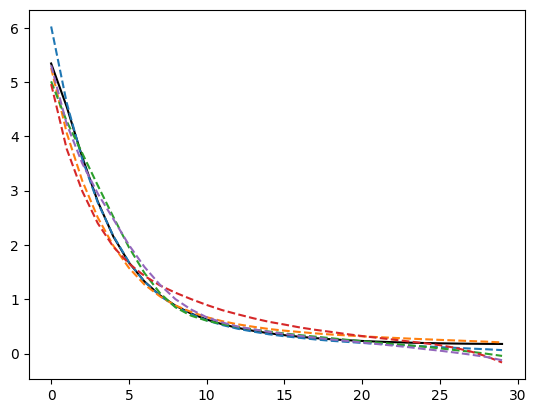

Wyniki dla p = 100
         Metoda Norma Frobeniusa     Norma 1    Norma 2 Różnica wartości własnych   Cos kąta
         sample      10.07(0.03) 11.13(0.09) 4.00(0.05)                2.60(0.06) 0.35(0.02)
    ledoit_wolf       8.22(0.02)  7.92(0.04) 3.14(0.02)                0.41(0.03) 0.35(0.02)
        banding       4.41(0.04)  2.96(0.04) 1.65(0.02)                0.41(0.03) 0.46(0.02)
   banding_perm      13.72(0.01)  5.26(0.03) 4.58(0.01)                3.89(0.05) 0.12(0.01)
thresholding_cv       6.63(0.04)  3.94(0.05) 2.40(0.03)                0.53(0.03) 0.38(0.01)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
        banding        5.17(0.12)
   banding_perm        1.12(0.16)
thresholding_cv        0.32(0.00)


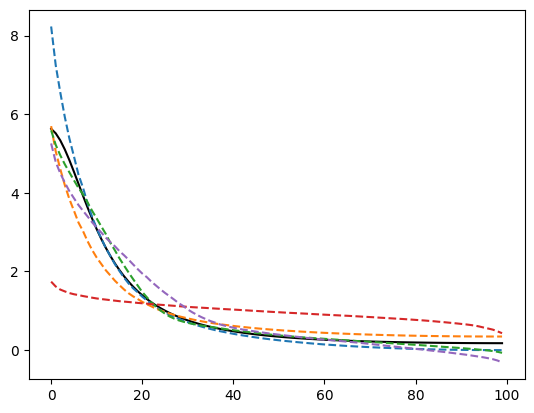

Wyniki dla p = 200
         Metoda Norma Frobeniusa     Norma 1    Norma 2 Różnica wartości własnych   Cos kąta
         sample      20.10(0.05) 21.86(0.13) 6.72(0.06)                5.27(0.07) 0.25(0.02)
    ledoit_wolf      14.04(0.01) 11.90(0.05) 3.81(0.01)                0.37(0.03) 0.25(0.02)
        banding       6.28(0.05)  3.35(0.05) 1.84(0.03)                0.61(0.04) 0.32(0.01)
   banding_perm      19.64(0.00)  5.39(0.04) 4.66(0.00)                3.91(0.04) 0.09(0.00)
thresholding_cv      10.07(0.06)  4.49(0.06) 2.71(0.02)                0.46(0.03) 0.24(0.01)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
        banding        5.77(0.12)
   banding_perm        1.20(0.17)
thresholding_cv        0.36(0.00)


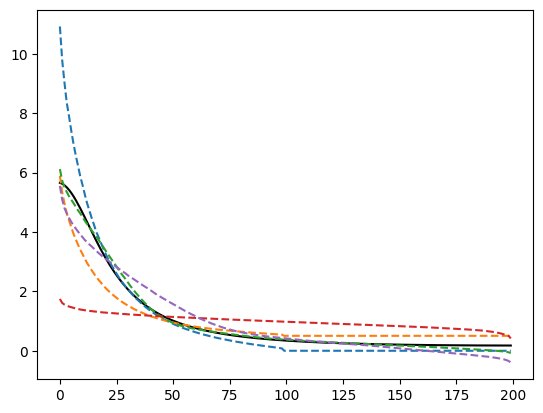

In [6]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.7
n = 100
N = 50
n_replicates = 100

save_dir = r"C:\Users\Mateusz\Desktop"
os.makedirs(save_dir, exist_ok=True)

for p in p_values:
    results, param_results = run_experiment(p, rho, n, N, n_replicates)

    data = []
    for method, est_matrices in results.items():
        fro_norms, one_norms, op_norms, eig_diffs, angles = [], [], [], [], []
        for est_matrix in est_matrices:
            fro, one, op, eig_diff, angle = evaluate_estimators(generate_AR1_covariance(p, rho), est_matrix)
            fro_norms.append(fro)   
            one_norms.append(one)
            op_norms.append(op)
            eig_diffs.append(eig_diff)
            angles.append(angle)
        
        data.append([
            method,
            f"{np.mean(fro_norms):.2f}({np.std(fro_norms) / np.sqrt(n):.2f})",
            f"{np.mean(one_norms):.2f}({np.std(one_norms) / np.sqrt(n):.2f})",
            f"{np.mean(op_norms):.2f}({np.std(op_norms) / np.sqrt(n):.2f})",
            f"{np.mean(eig_diffs):.2f}({np.std(eig_diffs) / np.sqrt(n):.2f})",
            f"{np.mean(angles):.2f}({np.std(angles) / np.sqrt(n):.2f})"
        ])

    columns = ['Metoda', 'Norma Frobeniusa', 'Norma 1', 'Norma 2',
               'Różnica wartości własnych', 'Cos kąta']
    df = pd.DataFrame(data, columns=columns)
    print(f"Wyniki dla p = {p}")
    print(df.to_string(index=False))

    param_data = []
    for method, params in param_results.items():
        param_data.append([
            method,
            f"{np.mean(params):.2f}({np.std(params) / np.sqrt(n):.2f})"
        ])

    param_df = pd.DataFrame(param_data, columns=['Metoda', 'Wartość parametru'])
    print("Średnie wartości dobranych parametrów:")
    print(param_df.to_string(index=False))

    # Unikalna nazwa pliku dla każdego wykresu
    filename = f"eigenvalues_p{p}.svg"
    save_path = os.path.join(save_dir, filename)

    plot_eigenvalues(generate_AR1_covariance(p, rho), results, p, save_path=save_path)


Wyniki dla p = 30
         Metoda Norma Frobeniusa    Norma 1    Norma 2 Różnica wartości własnych   Cos kąta
         sample       3.40(0.09) 5.11(0.16) 2.88(0.11)                2.01(0.13) 1.00(0.00)
    ledoit_wolf       3.38(0.09) 5.06(0.15) 2.90(0.11)                2.09(0.14) 1.00(0.00)
        banding       3.76(0.09) 5.37(0.16) 2.96(0.11)                2.01(0.14) 0.99(0.00)
   banding_perm       3.69(0.09) 5.34(0.16) 2.94(0.10)                2.00(0.13) 0.99(0.00)
thresholding_cv       3.40(0.09) 5.12(0.16) 2.88(0.11)                2.01(0.13) 1.00(0.00)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
        banding       26.78(0.20)
   banding_perm       26.94(0.17)
thresholding_cv        0.13(0.01)


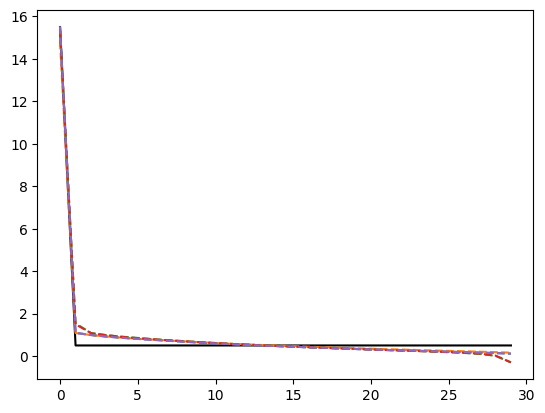

Wyniki dla p = 100
         Metoda Norma Frobeniusa     Norma 1    Norma 2 Różnica wartości własnych   Cos kąta
         sample      10.50(0.25) 17.55(0.43) 8.35(0.32)                4.98(0.42) 0.99(0.00)
    ledoit_wolf      10.67(0.29) 17.72(0.43) 8.76(0.36)                5.63(0.46) 0.99(0.00)
        banding      11.79(0.26) 18.50(0.41) 8.76(0.32)                5.12(0.42) 0.99(0.00)
   banding_perm      11.89(0.27) 18.42(0.43) 8.74(0.33)                5.05(0.44) 0.99(0.00)
thresholding_cv      10.51(0.25) 17.61(0.43) 8.35(0.32)                4.98(0.42) 0.99(0.00)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
        banding       90.40(0.64)
   banding_perm       89.54(0.61)
thresholding_cv        0.13(0.01)


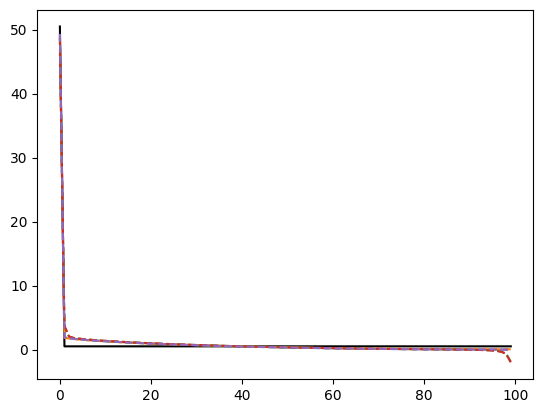

Wyniki dla p = 200
         Metoda Norma Frobeniusa     Norma 1     Norma 2 Różnica wartości własnych   Cos kąta
         sample      20.80(0.42) 37.31(0.83) 16.48(0.57)                9.70(0.75) 0.99(0.00)
    ledoit_wolf      20.63(0.46) 36.49(0.80) 16.57(0.61)               10.02(0.81) 0.99(0.00)
        banding      22.64(0.44) 38.53(0.81) 16.83(0.56)                9.77(0.75) 0.99(0.00)
   banding_perm      22.87(0.46) 38.41(0.84) 16.91(0.57)                9.80(0.76) 0.99(0.00)
thresholding_cv      20.85(0.42) 37.45(0.84) 16.49(0.57)                9.70(0.75) 0.99(0.00)
Średnie wartości dobranych parametrów:
         Metoda Wartość parametru
        banding      184.12(1.02)
   banding_perm      183.29(1.13)
thresholding_cv        0.14(0.01)


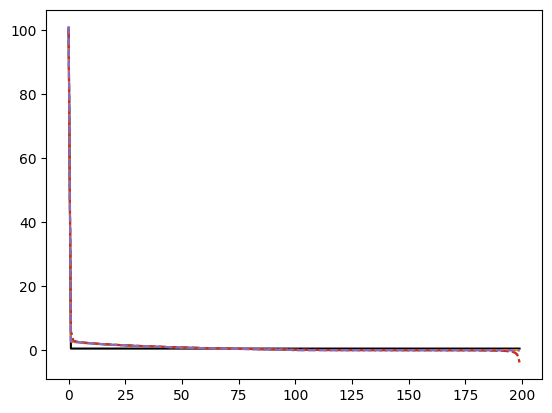

In [7]:
np.random.seed(42)
p_values = [30, 100, 200]
rho = 0.7
n = 100
N = 50
n_replicates = 100

save_dir = r"C:\Users\Mateusz\Desktop"
os.makedirs(save_dir, exist_ok=True)

for p in p_values:
    results, param_results = run_experiment2(p, n, N, n_replicates)

    data = []
    for method, est_matrices in results.items():
        fro_norms, one_norms, op_norms, eig_diffs, angles = [], [], [], [], []
        for est_matrix in est_matrices:
            fro, one, op, eig_diff, angle = evaluate_estimators(generate_dense_covariance(p), est_matrix)
            fro_norms.append(fro)   
            one_norms.append(one)
            op_norms.append(op)
            eig_diffs.append(eig_diff)
            angles.append(angle)
        
        data.append([
            method,
            f"{np.mean(fro_norms):.2f}({np.std(fro_norms) / np.sqrt(n):.2f})",
            f"{np.mean(one_norms):.2f}({np.std(one_norms) / np.sqrt(n):.2f})",
            f"{np.mean(op_norms):.2f}({np.std(op_norms) / np.sqrt(n):.2f})",
            f"{np.mean(eig_diffs):.2f}({np.std(eig_diffs) / np.sqrt(n):.2f})",
            f"{np.mean(angles):.2f}({np.std(angles) / np.sqrt(n):.2f})"
        ])

    columns = ['Metoda', 'Norma Frobeniusa', 'Norma 1', 'Norma 2',
               'Różnica wartości własnych', 'Cos kąta']
    df = pd.DataFrame(data, columns=columns)
    print(f"Wyniki dla p = {p}")
    print(df.to_string(index=False))

    param_data = []
    for method, params in param_results.items():
        param_data.append([
            method,
            f"{np.mean(params):.2f}({np.std(params) / np.sqrt(n):.2f})"
        ])

    param_df = pd.DataFrame(param_data, columns=['Metoda', 'Wartość parametru'])
    print("Średnie wartości dobranych parametrów:")
    print(param_df.to_string(index=False))

    # Unikalna nazwa pliku dla każdego wykresu
    filename = f"eigenvalues_dense_p{p}.svg"
    save_path = os.path.join(save_dir, filename)

    plot_eigenvalues(generate_dense_covariance(p), results, p, save_path=save_path)
